In [244]:
import pandas as pd
from tensorflow.keras.saving import load_model
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import yfinance as yf
from diebold_mariano import dm_test
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.dates import DateFormatter

## Some parameters

In [50]:
report = "reports_mid_price"

## Helper functions copied from src/models/lstm.py

In [51]:
def get_dates_for_training_scheme(df: pd.DataFrame):
    """
    This function returns all dates needed to train, validate and test the model. The training
    follows a rolling window type scheme. The data is trained on 4 days and validated on the 5th. 
    Some portion of the end of the dates are used for testing.

    Args:
        df (pd.DataFrame): dataframe with data.

    Returns:
        List[Tuples]: a list of tuples conatining the training and validation/test dates.
    """
    dates = df["sip_timestamp"].dt.day.unique()

    date_set = []

    num_days_training = 9
    num_days_val_test = 1

    for i in range(0, len(dates) - num_days_training, num_days_val_test):
        date_set.append((dates[i: i + num_days_training], dates[i + num_days_training: i + num_days_training + num_days_val_test]))

    return date_set

def train_val_test(df: pd.DataFrame, days: tuple[np.ndarray, np.ndarray]):
    """
    Splits a dataframe into training and val/test. The splitting is done by given dates.

    Args:
        df (pd.DataFrame): dataframe to split into training and test.
        days (tuple[np.ndarray, np.ndarray]): a tuple containing two arrays of train days and val/test days respectively

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: a train and val/test set of the original dataframe
    """
    
    train = df[df["sip_timestamp"].dt.day.isin(days[0])]
    val_test = df[df["sip_timestamp"].dt.day.isin(days[1])]

    return train, val_test

def create_sequences(data: np.ndarray, seq_length: int):
    """
    Convert DataFrame into sequences of specified length for LSTM input.

    Args: 
        data (np.array): complete data containing both x and y
        seq_length (int): the length of the sequence considered in the lstm.

    Returns:
        (np.array, np.array): x and y datasets with the sequences. 
    """
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length, :])  # all columns, including the last one, as features
        y.append(data[i + seq_length, -1])  # last column's lagged value as target

    return np.array(x), np.array(y)

def create_sequences_modified(data, seq_length):

    """
    Convert DataFrame into sequences of specified length for LSTM input. Makes sure sequences do not 
    contain data from different dates.

    Args: 
        data (np.array): complete data containing both x and y
        seq_length (int): the length of the sequence considered in the lstm.

    Returns:
        (np.array, np.array): x and y datasets with the sequences. 
    """
    X, y = [], []
    for date, group_data in data.groupby("date"):
        group_data = group_data.drop(columns=["date"]).values
        X_date, y_date = create_sequences(group_data, seq_length)
        X.append(X_date)
        y.append(y_date)
    return np.concatenate(X), np.concatenate(y)

def get_best_config(ticker: str):
    config_loss_df = pd.read_csv(f"../../reports_log/{report}/config_space_loss.csv")
    config_loss_df = config_loss_df[config_loss_df["ticker"] == ticker]
    
    id_min_loss = config_loss_df["mse"].idxmin()
    config = config_loss_df.loc[id_min_loss,:]
    config = config.drop(index = ["ticker", "mse"])
    config = config.to_dict()
    return config

def get_predictions(df, ticker):

    config = get_best_config(ticker)

    ticker_data = df[df["ticker"] == ticker].copy()
    ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
    ticker_data["date"] = ticker_data["sip_timestamp"].dt.date

    date_scheme = get_dates_for_training_scheme(ticker_data)

    num_days_testing = 6
    date_scheme_test = date_scheme[-num_days_testing:]

    tot_predictions = np.array([])
    tot_true = np.array([])
    tot_ts = np.array([], dtype=np.dtypes.DateTime64DType)

    for test_day in range(6):
        
        date_set = date_scheme_test[test_day]

        train, test = train_val_test(ticker_data, date_set)

        scaler = StandardScaler()

        ts = test["sip_timestamp"].iloc[config["seq_length"]:]
        tot_ts = np.concatenate((tot_ts, ts))

        train = train.drop(columns=["ticker", "sip_timestamp"])
        test = test.drop(columns=["ticker", "sip_timestamp"])

        scaler = StandardScaler()

        columns_to_standardize = train.columns[:-1] # standardize all columns except date

        for col in columns_to_standardize:
            scaler.fit(train.loc[train[col] != 0, [col]])
            train.loc[train[col] != 0, col] = scaler.transform(train.loc[train[col] != 0, [col]])
            test.loc[test[col] != 0, col] = scaler.transform(test.loc[test[col] != 0, [col]])

        X_train, y_train = create_sequences_modified(train, config["seq_length"])
        X_test, y_test = create_sequences_modified(test, config["seq_length"])

        model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

        y_pred = model.predict(X_test, verbose=False)
        
        tot_true = np.concatenate((tot_true, test.iloc[config["seq_length"]:, -2]))
        tot_predictions = np.concatenate((tot_predictions, y_pred.flatten()))

    return tot_ts, tot_true, tot_predictions, np.array([0]*tot_true.shape[0])

def save_all_predictions(report):
    df = pd.read_csv("../../data/processed/tq_data_gridded/df_tot_gridded.csv")
    predictions_df = pd.DataFrame(columns=["ts", "ticker", "true_y", "pred_y", "zero_mean"])
    for tick in df["ticker"].unique():
        if tick == "HFBL": continue
        sub_df = pd.DataFrame(columns=["ticker", "true_y", "pred_y", "zero_mean"])
        a = get_predictions(df, tick)
        sub_df[["ts", "true_y", "pred_y", "zero_mean"]] = np.array(a).T
        sub_df["ticker"] = tick
        predictions_df = pd.concat([predictions_df, sub_df], axis=0)
        if tick == "NYT":
            break
        
    predictions_df.to_csv(f"../../reports_log/{report}/all_predictions.csv", index=False)

def get_best_config_df(report):
    df_loss = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")
    best_config_dic = {}

    for ticker in df_loss["ticker"].unique():
        if ticker == "HFBL": continue
        try:
            best_config = get_best_config(ticker)
        except:
            break

        best_config_dic[ticker] = best_config


    best_config_df = pd.DataFrame().from_dict(best_config_dic, orient="index")
    best_config_df = best_config_df[["n_layers", "units", "l2_reg", "lr"]]
    best_config_df[["n_layers", "units"]] = best_config_df[["n_layers", "units"]].astype(int)
    best_config_df = best_config_df.iloc[:50, :].reset_index()

    return best_config_df

In [ ]:
# Saves all predictions, only has to be run once
save_all_predictions(report)

## Loading data and creating model

In [58]:
df = pd.read_csv("../../data/processed/tq_data_gridded/df_tot_gridded.csv")
predictions_df = pd.read_csv(f"../../reports_log/{report}/all_predictions.csv")
tot_loss_df = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")

In [222]:
df.columns

Index(['ticker', 'sip_timestamp', 'ask_size', 'bid_size',
       'mid_price_log_return'],
      dtype='object')

In [5]:
test_day = 0  # must be an element in [0, 1, 2, 3, 4, 5]
ticker = "ADSK"

In [123]:
zero_counts = (df["mid_price_log_return"] == 0).sum()
print(zero_counts/df.shape[0])

0.8380562209517431


In [129]:
mean_across_companies = df.groupby(by="ticker").apply(lambda x: (x["mid_price_log_return"] == 0).sum()/x.shape[0])
mean_across_companies = mean_across_companies.iloc[:50].sort_values(ascending=False)
mean_across_companies

/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_76624/2907067148.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_across_companies = df.groupby(by="ticker").apply(lambda x: (x["mid_price_log_return"] == 0).sum()/x.shape[0])


ticker
HFBL     0.998147
CFBK     0.994510
FGBI     0.993919
ICAD     0.992990
APYX     0.992652
BKD      0.966948
EPM      0.962545
ARTNA    0.957213
GCI      0.955407
CIVB     0.947703
ESRT     0.945907
AHH      0.941334
EAF      0.938694
AMED     0.936781
DVAX     0.936087
GNE      0.932325
CHE      0.932218
ALEC     0.927720
DOMO     0.920774
HTBI     0.920688
HLF      0.917365
IBCP     0.914918
BELFB    0.910504
CRMT     0.910483
BV       0.896665
CRMD     0.880744
BANF     0.875123
LYTS     0.873680
FWONA    0.872312
CNA      0.862535
KEY      0.860643
COHU     0.844101
JELD     0.843984
CRBP     0.830466
CWT      0.827260
ARVN     0.826822
EVTC     0.820346
FULT     0.805236
IPG      0.803708
FDS      0.782069
CLDX     0.771885
MEDP     0.760889
BTU      0.760344
GDDY     0.751923
HAL      0.734901
CB       0.711755
ADSK     0.675016
FITB     0.600641
MARA     0.545854
AEP      0.373862
dtype: float64

In [7]:
ticker_data = df[df["ticker"] == ticker].copy()
ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
ticker_data["date"] = ticker_data["sip_timestamp"].dt.date

In [8]:
config = get_best_config(ticker)
# config = {'seq_length': 60, 'n_layers': 3, 'units': 16, 'n_features': 1.0, 'l2_reg': 0.0}

date_scheme = get_dates_for_training_scheme(ticker_data)

num_days_testing = 6
date_scheme_test = date_scheme[-num_days_testing:]
date_set = date_scheme_test[test_day]

train, test = train_val_test(ticker_data, date_set)

scaler = StandardScaler()

ts = test["sip_timestamp"].iloc[config["seq_length"]:]

train = train.drop(columns=["ticker", "sip_timestamp"])
test = test.drop(columns=["ticker", "sip_timestamp"])

scaler = StandardScaler()

columns_to_standardize = train.columns[:-1] # standardize all columns except date

for col in columns_to_standardize:
    scaler.fit(train.loc[train[col] != 0, [col]])
    train.loc[train[col] != 0, col] = scaler.transform(train.loc[train[col] != 0, [col]])
    test.loc[test[col] != 0, col] = scaler.transform(test.loc[test[col] != 0, [col]])

# train.loc[:, train.columns != "date"] = scaler.fit_transform(train.loc[:, train.columns != "date"])
# test.loc[:, test.columns != "date"] = scaler.transform(test.loc[:, test.columns != "date"])

X_train, y_train = create_sequences_modified(train, config["seq_length"])
X_test, y_test = create_sequences_modified(test, config["seq_length"])

model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

y_pred = model.predict(X_test).flatten()

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [9]:
config

{'seq_length': 12,
 'n_layers': 3.0,
 'units': 12.0,
 'l2_reg': 0.0652471656694728,
 'lr': 0.0130134689488177,
 'n_features': 6.0}

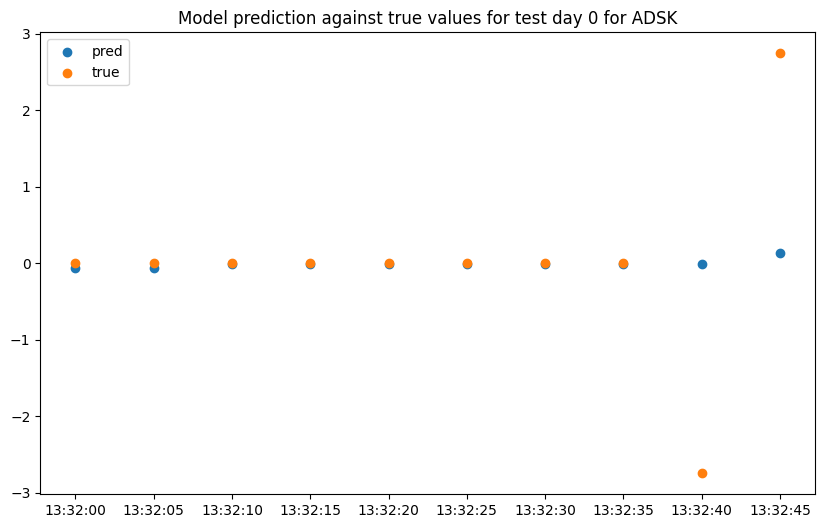

In [10]:
subset = slice(10, 20)

plt.figure(figsize=(10, 6))
plt.scatter(ts.iloc[subset], y_pred[subset], label="pred")
plt.scatter(ts.iloc[subset], y_test[subset], label="true")
plt.legend()
plt.title(f"Model prediction against true values for test day {test_day} for {ticker}")
plt.show()

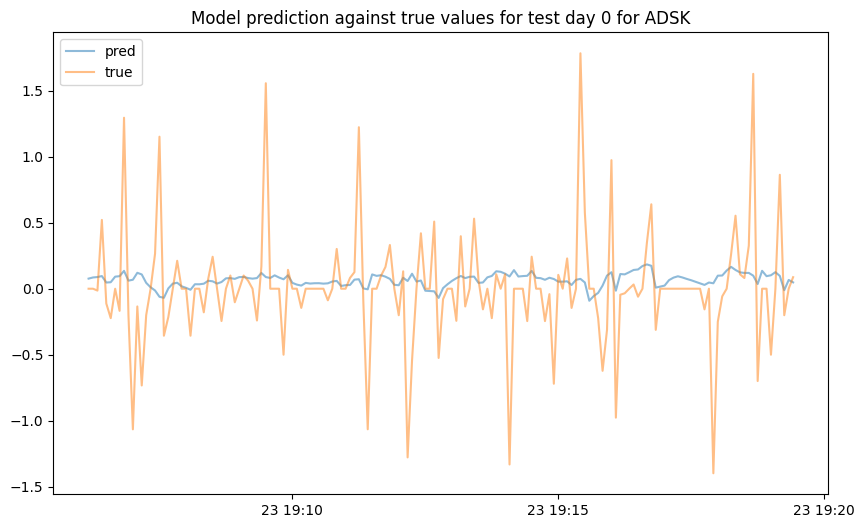

In [11]:
mn = 4020
mx = 4180

plt.figure(figsize=(10, 6))
plt.plot(ts.iloc[mn:mx], y_pred[mn:mx], label="pred", alpha=0.5)
plt.plot(ts.iloc[mn:mx], y_test[mn:mx], label="true", alpha=0.5)
plt.legend()
plt.title(f"Model prediction against true values for test day {test_day} for {ticker}")
plt.show()

In [12]:
model_loss = np.mean((y_test-y_pred)**2)
martingale_loss = np.mean((y_test-0)**2)

print(f"Model loss {model_loss}")
print(f"Martingale loss {martingale_loss}")

if model_loss <= martingale_loss:
    print("Model better")
else:
    print("Martingale better")

Model loss 0.3444646575743043
Martingale loss 0.3486323424803441
Model better


### Loss all tickers (all values)

In [2]:
df = pd.read_csv("../../data/processed/tq_data_gridded/df_tot_gridded.csv")

In [68]:
tot_loss_dic = {}

for ticker in df["ticker"].unique():
    if ticker == "HFBL": continue
    print(f"{ticker}")
    tot_loss_dic[ticker] = {"test_day": [], "model_loss": [], "martingale_loss": [], "model_best": []}

    ticker_data = df[df["ticker"] == ticker].copy()
    ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
    ticker_data["date"] = ticker_data["sip_timestamp"].dt.date
    try:
        config = get_best_config(ticker)
    except:
        break

    date_scheme = get_dates_for_training_scheme(ticker_data)

    num_days_testing = 6
    date_scheme_test = date_scheme[-num_days_testing:]

    
    for test_day in range(6):
        date_set = date_scheme_test[test_day]

        train, test = train_val_test(ticker_data, date_set)

        scaler = StandardScaler()

        train = train.drop(columns=["ticker", "sip_timestamp"])
        test = test.drop(columns=["ticker", "sip_timestamp"])

        scaler = StandardScaler()

        columns_to_standardize = train.columns[:-1] # standardize all columns except date

        for col in columns_to_standardize:
            scaler.fit(train.loc[train[col] != 0, [col]])
            train.loc[train[col] != 0, col] = scaler.transform(train.loc[train[col] != 0, [col]])
            test.loc[test[col] != 0, col] = scaler.transform(test.loc[test[col] != 0, [col]])

        X_train, y_train = create_sequences_modified(train, config["seq_length"])
        X_test, y_test = create_sequences_modified(test, config["seq_length"])

        model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

        y_pred = model.predict(X_test, verbose=False).flatten()

        model_loss = np.mean((y_test-y_pred)**2)
        martingale_loss = np.mean((y_test-0)**2)

        tot_loss_dic[ticker]["test_day"].append(test_day)
        tot_loss_dic[ticker]["model_loss"].append(model_loss)
        tot_loss_dic[ticker]["martingale_loss"].append(martingale_loss)
        tot_loss_dic[ticker]["model_best"].append(1 if model_loss <= martingale_loss else 0)


ADSK
AEP
AHH
ALEC
AMED
APYX
ARTNA
ARVN
BANF
BELFB
BKD
BTU
BV
CB
CFBK
CHE
CIVB
CLDX
CNA
COHU
CRBP
CRMD
CRMT
CWT
DOMO
DVAX
EAF
EPM
ESRT
EVTC
FDS
FGBI
FITB
FULT
FWONA
GCI
GDDY
GNE
HAL
HLF
HTBI
IBCP
ICAD
IPG
JELD
KEY
LYTS
MARA
MEDP
MESA
MMM
NDAQ
NGVT
NNI
NVEC
NX
NYT
OPI


In [69]:
df_list = []
for ticker, data in tot_loss_dic.items():
    temp_df = pd.DataFrame(data) 
    temp_df['ticker'] = ticker    
    df_list.append(temp_df)

result_df = pd.concat(df_list, ignore_index=True)

result_df

,test_day,model_loss,martingale_loss,model_best,ticker
0,0.0,0.254650,0.258334,1.0,ADSK
1,1.0,0.204947,0.205631,1.0,ADSK
2,2.0,0.228509,0.229583,1.0,ADSK
3,3.0,0.173173,0.175053,1.0,ADSK
4,4.0,0.222596,0.225372,1.0,ADSK
...,...,...,...,...,...
337,1.0,0.144700,0.145025,1.0,NYT
338,2.0,0.166844,0.166804,0.0,NYT
339,3.0,0.271142,0.272424,1.0,NYT
340,4.0,0.232145,0.232332,1.0,NYT


In [70]:
result_df.model_best.mean()

0.3742690058479532

In [ ]:
worst_results = result_df.groupby("ticker")[["model_best"]].sum().sort_values(by="model_best").reset_index()
worst_results = worst_results.rename(columns={"model_best": "Number of days", "ticker": "Ticker"})

with open("tickers_never_outperformed.tex", "w") as file:
    latex_table = worst_results.head(11).to_latex(
        index=False,
        header=True,
        float_format="%.0f",
        caption="Number of test days where LSTM outperforms martingale",
        label="tab:tickers_never_outperformed",
    )
    latex_table = latex_table.replace("\\begin{table}", "\\begin{table}[H]\n\\centering")
    file.write(latex_table)

worst_results

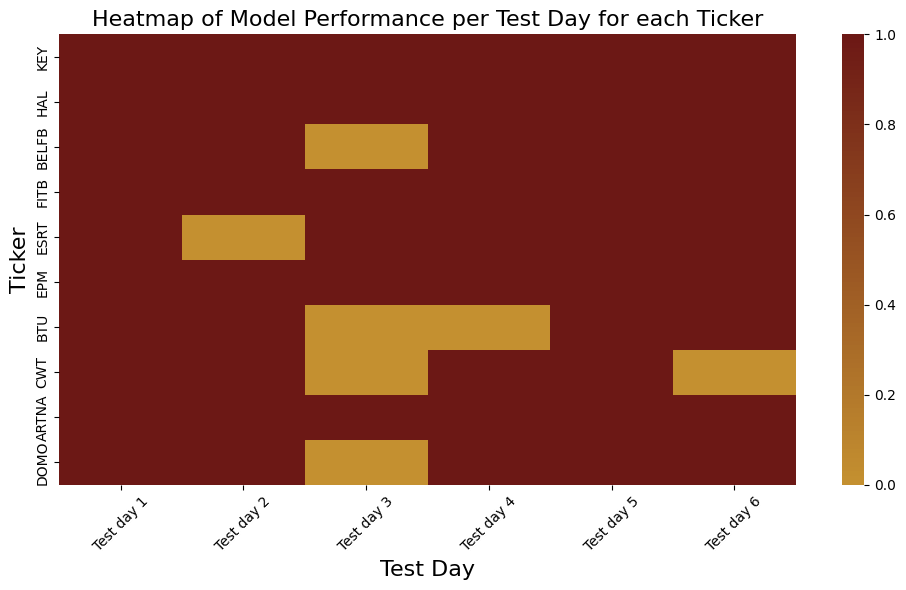

In [284]:
# winning_stocks = tot_loss_df.loc[tot_loss_df["normalized_rmse"] <= 1]
winning_stocks = tot_loss_df.loc[tot_loss_df["ticker"].isin(significant_tickers)]
winning_stocks = winning_stocks.sort_values(by="normalized_rmse")["ticker"]
pivoted_df = result_df.pivot(index="ticker", columns="test_day", values="model_best")

pivoted_df = pivoted_df.loc[winning_stocks.values,:]
# Optional: Rename columns for clarity
pivoted_df.columns = [f"Test day {int(col) + 1}" for col in pivoted_df.columns]
pivoted_df


colors = ["#c49030", "#6c1815"]  # Example HEX colors
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

plt.figure(figsize=(10, 6))
sns.heatmap(pivoted_df, fmt=".2f", cmap=custom_cmap, cbar=True)

# Customize plot
plt.title("Heatmap of Model Performance per Test Day for each Ticker", fontsize = 16)
plt.xlabel("Test Day", fontsize = 16)
plt.ylabel("Ticker", fontsize = 16)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the heatmap
plt.savefig("5_days_outperform.png")
plt.show()

In [71]:
df_tot_loss = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")
better_tickers = df_tot_loss.loc[df_tot_loss["normalized_rmse"] <= 1, "ticker"]


better_models = result_df.loc[result_df["ticker"].isin(better_tickers), :]
test_days_beaten = better_models.groupby(by=["ticker"])[["model_best"]].sum().sort_values(by="model_best", ascending=False).reset_index()
test_days_beaten = test_days_beaten.rename(columns={"model_best": "Number of days", "ticker": "Ticker"})

with open("num_days_outperform.tex", "w") as file:
    latex_table = test_days_beaten.to_latex(
        index=False,
        header=True,
        float_format="%.0f",
        caption="Number of test days where LSTM outperforms martingale",
        label="tab:num_days_outperform",
    )
    latex_table = latex_table.replace("\\begin{table}", "\\begin{table}[H]\n\\centering")
    file.write(latex_table)

test_days_beaten

,Ticker,Number of days
0,ARTNA,6.0
1,EPM,6.0
2,FITB,6.0
3,HAL,6.0
4,BELFB,5.0
5,DOMO,5.0
6,ESRT,5.0
7,GDDY,5.0
8,BTU,4.0
9,CWT,4.0


In [133]:
results_per_day = result_df.groupby(by="test_day")[["model_best"]].mean().reset_index()
results_per_day["test_day"] = results_per_day["test_day"].astype(int)
results_per_day["model_best"] = results_per_day["model_best"]*100
results_per_day = results_per_day.rename(columns={"test_day": "Test day", "model_best": "Percent beat (\\%)"})

with open("percent_days_outperform_total.tex", "w") as file:
    latex_table = results_per_day.to_latex(
        index=False,
        header=True,
        float_format="%.2f",
        caption="LSTM model outperforms martingale",
        label="tab:percent_days_outperform_total",
    )
    latex_table = latex_table.replace("\\begin{table}", "\\begin{table}[H]\n\\centering")
    file.write(latex_table)

results_per_day

,Test day,Percent beat (\%)
0,0,48.717949
1,1,41.025641
2,2,30.769231
3,3,46.153846
4,4,38.461538
5,5,30.769231


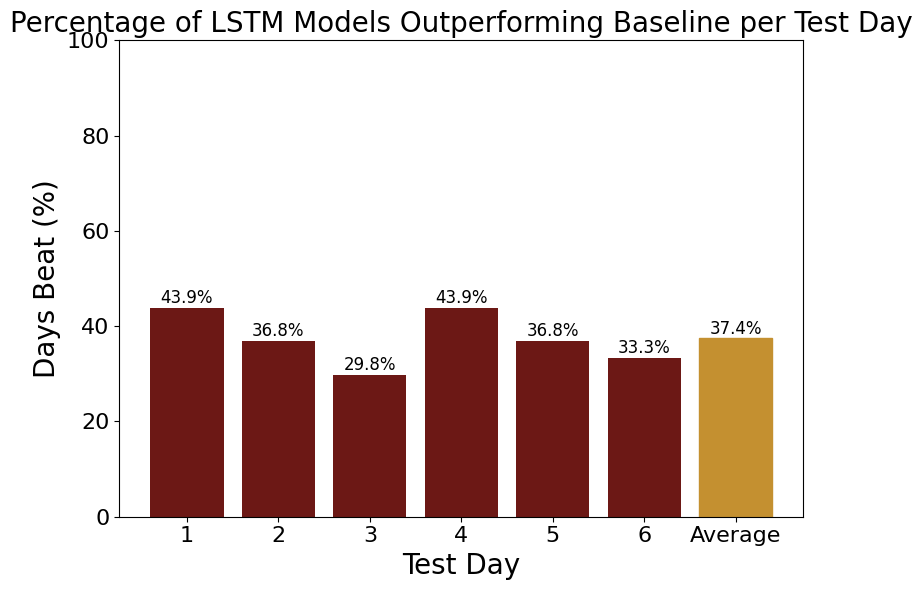

In [308]:
results_per_day = result_df.groupby(by="test_day")[["model_best"]].mean().reset_index()
results_per_day["test_day"] = results_per_day["test_day"].astype(int)
results_per_day["model_best"] = results_per_day["model_best"]*100
results_per_day["test_day"] = results_per_day["test_day"] + 1
# average_df = pd.DataFrame().from_dict({"test_day": ["Average"], "model_best": [results_per_day["model_best"].mean()]})
results_per_day = pd.concat([results_per_day,pd.DataFrame().from_dict({"test_day": ["Average"], "model_best": [results_per_day["model_best"].mean()]})], axis = 0, ignore_index=True)
results_per_day["test_day"] = results_per_day["test_day"].astype(str)


# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(results_per_day['test_day'], results_per_day['model_best'], color="#6c1815")


# Add labels to the bars with percentage values
for bar, percent in zip(bars, results_per_day['model_best']):
    if percent == results_per_day["model_best"].mean():
        bar.set_color("#c49030")
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of bar)
        height + 1,                        # Y-coordinate (just above the bar)
        f'{percent:.1f}%',                 # Text (formatted percentage)
        ha='center', fontsize=12, color='black'  # Center alignment, font size, color
    )

# Add labels, title, and formatting
ax.set_xlabel("Test Day", fontsize=20)
ax.set_ylabel("Days Beat (%)", fontsize=20)
ax.set_title("Percentage of LSTM Models Outperforming Baseline per Test Day", fontsize=20)
ax.set_ylim(0, 100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig("5_percent_days_outperform_total.png")
plt.show()


### Loss for only nonzero values

In [6]:
df_loss = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")

df_table = df_loss.sort_values(by="normalized_rmse", ascending=True)
df_table = df_table[df_table["normalized_rmse"] < 1]

p_values = []
for tick in df_table["ticker"]:
    a = get_predictions(df, tick)[1:]
    stat, p = dm_test(*a, int((a[0].shape[0]/1000)**0.25))
    p_values.append(p)

df_table["p-value"] = p_values

df_table = df_table.rename(columns={"ticker": "Ticker", "normalized_rmse": "Normalized RMSE"})

with open("loss_per_ticker_0.tex", "w") as file:
    latex_table = df_table[["Ticker", "Normalized RMSE", "p-value"]].to_latex(
        index=False,
        header=True,
        float_format="%.5f",
        caption="Loss per ticker",
        label="tab:loss_per_ticker_0",
    )
    latex_table = latex_table.replace("\\begin{table}", "\\begin{table}[H]\n\\centering")
    file.write(latex_table)


In [ ]:
def rmse_excluding_0(df, ticker):

    config = get_best_config(ticker)

    ticker_data = df[df["ticker"] == ticker].copy()
    ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
    ticker_data["date"] = ticker_data["sip_timestamp"].dt.date

    date_scheme = get_dates_for_training_scheme(ticker_data)

    num_days_testing = 6
    date_scheme_test = date_scheme[-num_days_testing:]

    tot_predictions = np.array([])
    tot_true = np.array([])

    for test_day in range(6):
        
        date_set = date_scheme_test[test_day]

        train, test = train_val_test(ticker_data, date_set)

        scaler = StandardScaler()

        ts = test["sip_timestamp"].iloc[config["seq_length"]:]

        train = train.drop(columns=["ticker", "sip_timestamp"])
        test = test.drop(columns=["ticker", "sip_timestamp"])

        scaler = StandardScaler()

        columns_to_standardize = train.columns[:-1] # standardize all columns except date

        for col in columns_to_standardize:
            scaler.fit(train.loc[train[col] != 0, [col]])
            train.loc[train[col] != 0, col] = scaler.transform(train.loc[train[col] != 0, [col]])
            test.loc[test[col] != 0, col] = scaler.transform(test.loc[test[col] != 0, [col]])

        X_train, y_train = create_sequences_modified(train, config["seq_length"])
        X_test, y_test = create_sequences_modified(test, config["seq_length"])

        model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

        y_pred = model.predict(X_test, verbose=False)

        # scaling back
        # test.loc[test[col] != 0, col] = scaler.inverse_transform(test.loc[test[col] != 0, [col]])
        # y_pred = scaler.inverse_transform(y_pred)
        
        tot_true = np.concatenate((tot_true, test.iloc[config["seq_length"]:, -2]))
        tot_predictions = np.concatenate((tot_predictions, y_pred.flatten()))
    
    nonzero_mask = tot_true != 0

    normalized_rmse = np.mean((tot_predictions[nonzero_mask]-tot_true[nonzero_mask])**2)**0.5 / np.std(tot_true[nonzero_mask])

    stat, p = dm_test(tot_true, tot_predictions, np.array([0]*tot_true.shape[0]), int((tot_true.shape[0]/1000)**0.25))

    return normalized_rmse, p

ticker_col = []
normalized_mse_nonzero= []
p_values_1 = []

for ticker in df["ticker"].unique():
    if ticker == "HFBL":
        continue
    print(f"{ticker}")
    try:
        rmse, p = rmse_excluding_0(df, ticker)
    except:
        break
    normalized_mse_nonzero.append(rmse)
    ticker_col.append(ticker)
    p_values_1.append(p)

df_loss_nonzero = pd.DataFrame({
    "Ticker": ticker_col,
    "Normalized RMSE (excluding zeros)": normalized_mse_nonzero,
    "P-value": p_values_1,
})




ADSK
AEP
AHH
ALEC
AMED
APYX
ARTNA
ARVN
BANF
BELFB
BKD
BTU
BV
CB
CFBK
CHE
CIVB
CLDX
CNA
COHU
CRBP
CRMD
CRMT
CWT
DOMO
DVAX
EAF
EPM
ESRT
EVTC
FDS
FGBI
FITB
FULT
FWONA
GCI
GDDY
GNE
HAL
HLF
HTBI
IBCP
ICAD
IPG
JELD
KEY
LYTS
MARA
MEDP
MESA
MMM
NDAQ
NGVT
NNI
NVEC
NX
NYT
OPI


In [97]:
df_loss_nonzero = df_loss_nonzero.sort_values(by="Normalized RMSE (excluding zeros)", ascending=True)

with open("loss_per_ticker_1.tex", "w") as file:
    latex_table = df_loss_nonzero.head(33).to_latex(
        index=False,
        header=True,
        float_format="%.5f",
        caption="Loss per ticker (excluding zeros)",
        label="tab:loss_per_ticker_1",
    )
    latex_table = latex_table.replace("\\begin{table}", "\\begin{table}[H]\n\\centering")
    file.write(latex_table)

df_loss_nonzero

,Ticker,Normalized RMSE (excluding zeros),P-value
45,KEY,0.942518,2.233580e-23
38,HAL,0.970450,2.309664e-18
28,ESRT,0.979940,2.344298e-05
32,FITB,0.981762,4.024586e-34
9,BELFB,0.985252,6.623014e-03
0,ADSK,0.990638,5.859168e-01
25,DVAX,0.991859,3.079262e-01
13,CB,0.992248,2.699022e-01
36,GDDY,0.992809,2.001482e-01
56,NYT,0.993300,2.958820e-05


In [45]:
tot_loss_dic = {}

for ticker in df["ticker"].unique():
    print(f"{ticker}")
    tot_loss_dic[ticker] = {"test_day": [], "model_loss": [], "martingale_loss": [], "model_best": []}

    ticker_data = df[df["ticker"] == ticker].copy()
    ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
    ticker_data["date"] = ticker_data["sip_timestamp"].dt.date
    try:
        config = get_best_config(ticker)
    except:
        break

    date_scheme = get_dates_for_training_scheme(ticker_data)

    num_days_testing = 6
    date_scheme_test = date_scheme[-num_days_testing:]

    
    for test_day in range(6):
        date_set = date_scheme_test[test_day]

        train, test = train_val_test(ticker_data, date_set)

        scaler = StandardScaler()

        train = train.drop(columns=["ticker", "sip_timestamp"])
        test = test.drop(columns=["ticker", "sip_timestamp"])

        scaler = StandardScaler()

        columns_to_standardize = train.columns[:-1] # standardize all columns except date

        for col in columns_to_standardize:
            scaler.fit(train.loc[train[col] != 0, [col]])
            train.loc[train[col] != 0, col] = scaler.transform(train.loc[train[col] != 0, [col]])
            test.loc[test[col] != 0, col] = scaler.transform(test.loc[test[col] != 0, [col]])

        X_train, y_train = create_sequences_modified(train, config["seq_length"])
        X_test, y_test = create_sequences_modified(test, config["seq_length"])

        model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

        y_pred = model.predict(X_test, verbose=False).flatten()
        
        # excluding nonzero values
        nonzero_mask = y_test != 0

        model_loss = np.mean((y_test[nonzero_mask] - y_pred[nonzero_mask])**2)
        martingale_loss = np.mean((y_test[nonzero_mask] - 0)**2)

        tot_loss_dic[ticker]["test_day"].append(test_day)
        tot_loss_dic[ticker]["model_loss"].append(model_loss)
        tot_loss_dic[ticker]["martingale_loss"].append(martingale_loss)
        tot_loss_dic[ticker]["model_best"].append(1 if model_loss <= martingale_loss else 0)


ADSK
AEP
AHH
ALEC
AMED
APYX
ARTNA
ARVN
BANF
BELFB
BKD
BTU
BV
CB
CFBK
CHE
CIVB
CLDX
CNA
COHU
CRBP
CRMD
CRMT
CWT
DOMO
DVAX
EAF
EPM
ESRT
EVTC
FDS
FGBI
FITB
FULT
FWONA
GCI
GDDY
GNE
HAL
HFBL


In [46]:
df_list = []
for ticker, data in tot_loss_dic.items():
    temp_df = pd.DataFrame(data) 
    temp_df['ticker'] = ticker    
    df_list.append(temp_df)

result_df_nonzero = pd.concat(df_list, ignore_index=True)

result_df_nonzero

,test_day,model_loss,martingale_loss,model_best,ticker
0,0.0,0.651058,0.667578,1.0,ADSK
1,1.0,0.814753,0.833778,1.0,ADSK
2,2.0,0.771659,0.776425,1.0,ADSK
3,3.0,0.622420,0.632822,1.0,ADSK
4,4.0,0.761645,0.776244,1.0,ADSK
...,...,...,...,...,...
229,1.0,0.887707,0.954794,1.0,HAL
230,2.0,0.919779,0.957961,1.0,HAL
231,3.0,1.374500,1.434873,1.0,HAL
232,4.0,0.879814,0.932164,1.0,HAL


In [ ]:
result_df_nonzero.model_best.mean()

In [132]:
results_per_day_nonzero = result_df_nonzero.groupby(by="test_day")[["model_best"]].mean().reset_index()
results_per_day_nonzero["test_day"] = results_per_day_nonzero["test_day"].astype(int)
results_per_day_nonzero["model_best"] = results_per_day_nonzero["model_best"]*100
results_per_day_nonzero = results_per_day_nonzero.rename(columns={"test_day": "Test day", "model_best": "Percent beat (\\%)"})

with open("percent_days_outperform_total_1.tex", "w") as file:
    latex_table = results_per_day_nonzero.to_latex(
        index=False,
        header=True,
        float_format="%.2f",
        caption="LSTM model outperforms martingale (only inlcuding nonzero values)",
        label="tab:percent_days_outperform_total_1",
    )
    latex_table = latex_table.replace("\\begin{table}", "\\begin{table}[H]\n\\centering")
    file.write(latex_table)

results_per_day_nonzero

,Test day,Percent beat (\%)
0,0,71.794872
1,1,76.923077
2,2,64.102564
3,3,69.230769
4,4,61.538462
5,5,61.538462


### Plots of loss
These plots might be better using a log transform...

In [111]:
# config_loss = pd.read_csv(f"../../reports_log/{report}/config_space_loss.csv")
config_loss = pd.read_csv(f"../../reports/config_space_loss.csv")

In [112]:
config_loss = config_loss.drop([529, 159])
config_loss = config_loss.sort_values(by="mse", ascending=False)
config_loss

,ticker,seq_length,n_layers,units,mse,l2_reg,lr,n_features
423,CRMD,12,4.0,12.0,7.707146,0.000026,9.653231e-01,3.0
691,FWONA,12,3.0,32.0,2.962010,0.000027,1.693261e-05,3.0
349,CLDX,12,3.0,12.0,2.610880,0.000496,9.231771e-07,3.0
557,EPM,12,2.0,4.0,2.213583,0.000098,2.271112e-04,3.0
551,EPM,12,3.0,12.0,2.156224,0.000081,1.066792e-04,3.0
...,...,...,...,...,...,...,...,...
628,FGBI,12,4.0,8.0,0.003751,0.041418,1.366290e-01,3.0
620,FGBI,12,4.0,28.0,0.003750,35.726176,8.425820e-03,3.0
638,FGBI,12,2.0,16.0,0.003750,3.432952,9.580961e-04,3.0
623,FGBI,12,2.0,28.0,0.003750,15.736163,1.462814e-02,3.0


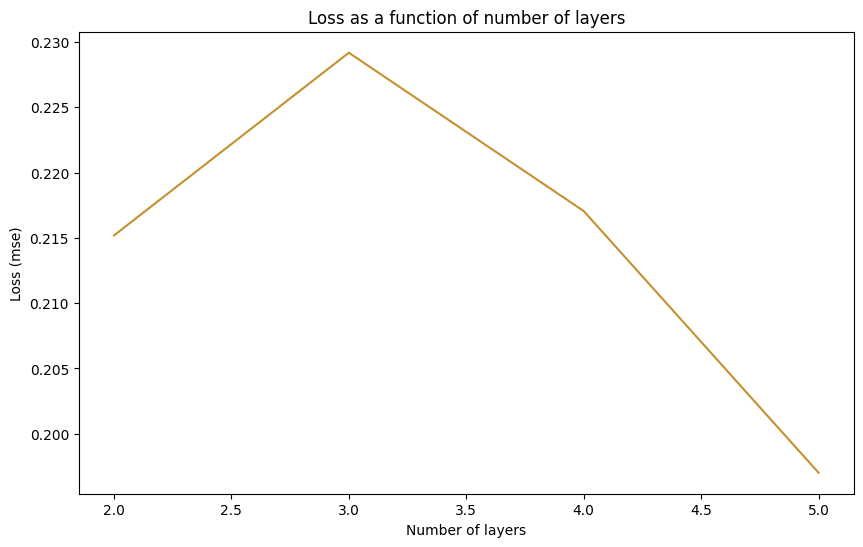

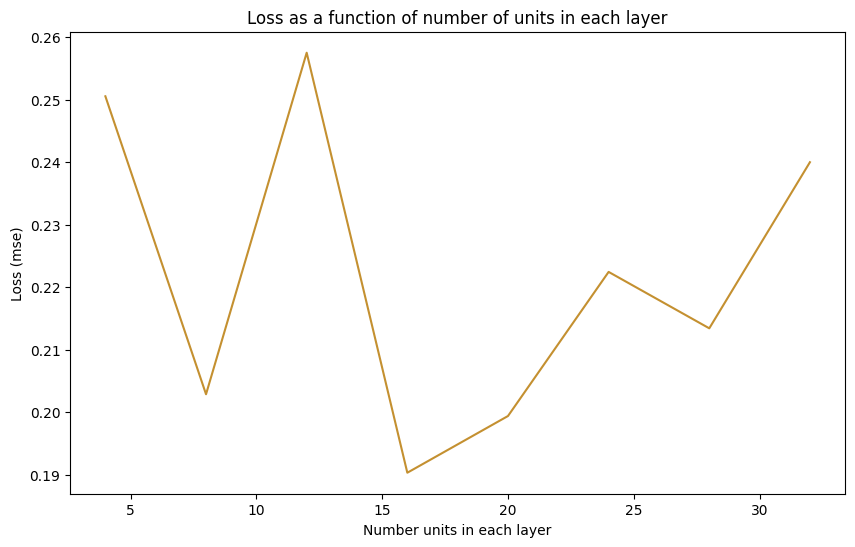

Index(['mse', 'bucket'], dtype='object')


/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_35114/1823042501.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_loss = loss_per_hyper.groupby('bucket').mean()


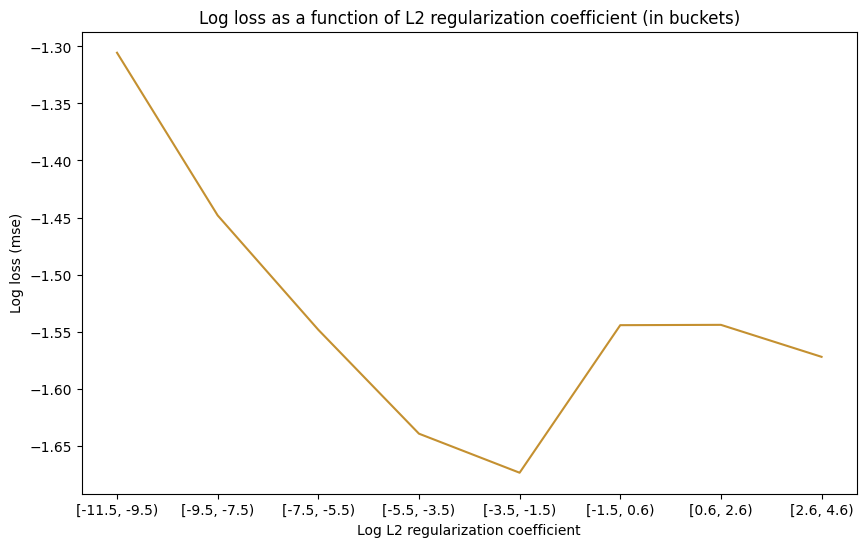

Index(['mse', 'bucket'], dtype='object')


/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_35114/1823042501.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_loss = loss_per_hyper.groupby('bucket').mean()


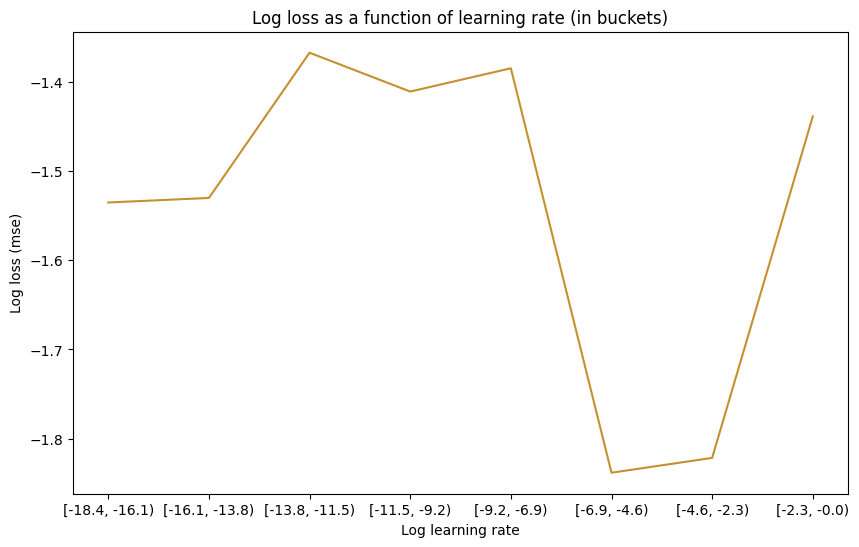

In [95]:
columns = ["n_layers", "units", "l2_reg", "lr"]

plot_data = {
    "n_layers": {
        "title": "Loss as a function of number of layers",
        "xlabel": "Number of layers",
        "ylabel": "Loss (mse)",
        "scale": "identity",
    },

    "units": {
        "title": "Loss as a function of number of units in each layer",
        "xlabel": "Number units in each layer",
        "ylabel": "Loss (mse)",
        "scale": "identity",
    },

    "l2_reg": {
        "title": "Log loss as a function of L2 regularization coefficient (in buckets)",
        "xlabel": "Log L2 regularization coefficient",
        "ylabel": "Log loss (mse)",
        "scale": "log",
    },

    "lr": {
        "title": "Log loss as a function of learning rate (in buckets)",
        "xlabel": "Log learning rate",
        "ylabel": "Log loss (mse)",
        "scale": "log",
    },

}

for col in columns:
    # if col != "l2_reg":
    #     continue
    loss_per_hyper = config_loss.groupby(by=col)["mse"].mean()
    # print(loss_per_hyper)
    # break

    plt.figure(figsize=(10, 6))
    if col in ["l2_reg", "lr"]:
        loss_per_hyper.index = np.log(loss_per_hyper.index)
        num_buckets = 8
        bucket_edges = np.linspace(loss_per_hyper.index.min(), loss_per_hyper.index.max(), num_buckets + 1)

        # Assign each index to a bucket
        bucket_labels = range(1, num_buckets + 1)
        loss_per_hyper = pd.DataFrame(loss_per_hyper)
        bucket_labels = [f"[{bucket_edges[i]:.1f}, {bucket_edges[i + 1]:.1f})" for i in range(len(bucket_edges) - 1)]
        loss_per_hyper['bucket'] = pd.cut(loss_per_hyper.index, bins=bucket_edges, labels=bucket_labels, include_lowest=True)
        print(loss_per_hyper.columns)
        # Aggregate the loss values by buckets
        aggregated_loss = loss_per_hyper.groupby('bucket').mean()

        plt.plot(np.log(aggregated_loss), "#c49030")
    else:
        plt.plot(loss_per_hyper, "#c49030")
    plt.xlabel(plot_data[col]["xlabel"])
    plt.ylabel(plot_data[col]["ylabel"])
    plt.title(plot_data[col]["title"])
    plt.savefig(f"5_{col}_loss.png")
    plt.show()

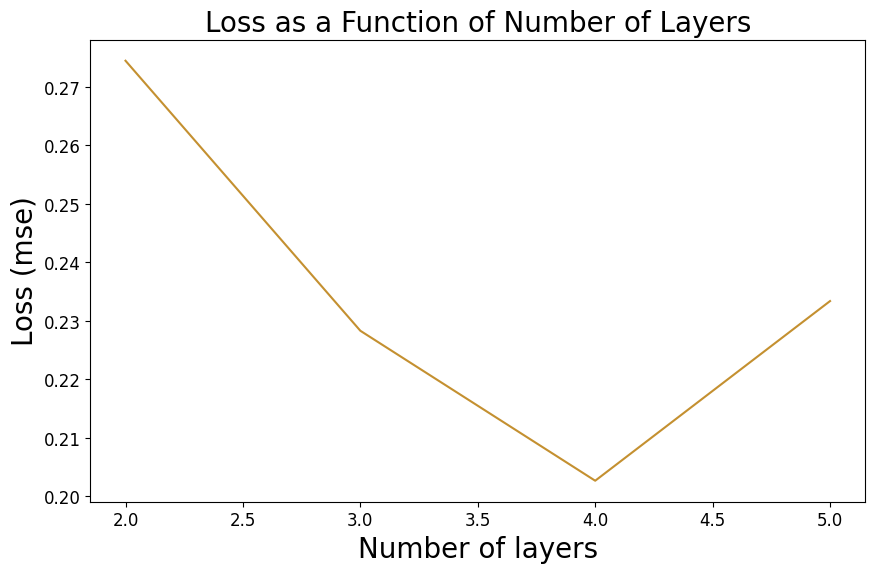

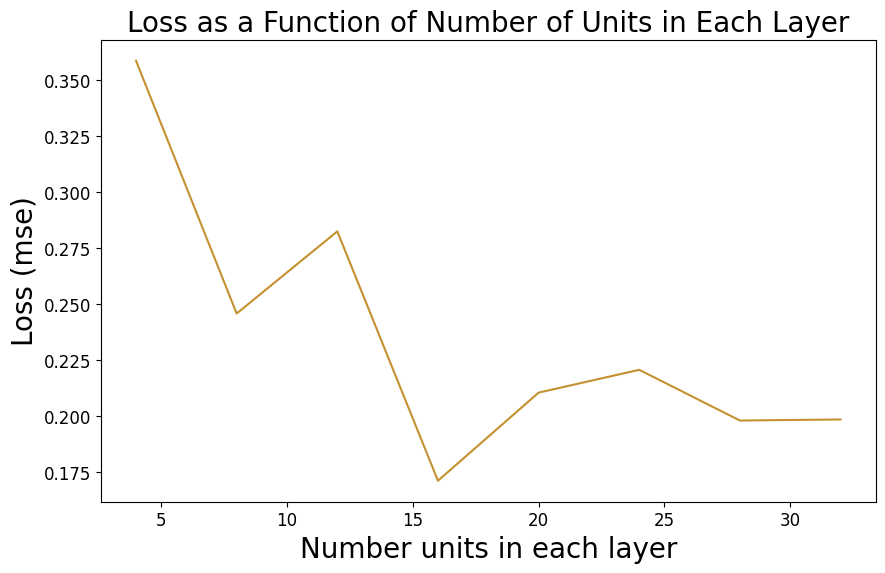

Index(['mse', 'bucket'], dtype='object')


/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_35114/1263575373.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_loss = loss_per_hyper.groupby('bucket').mean()


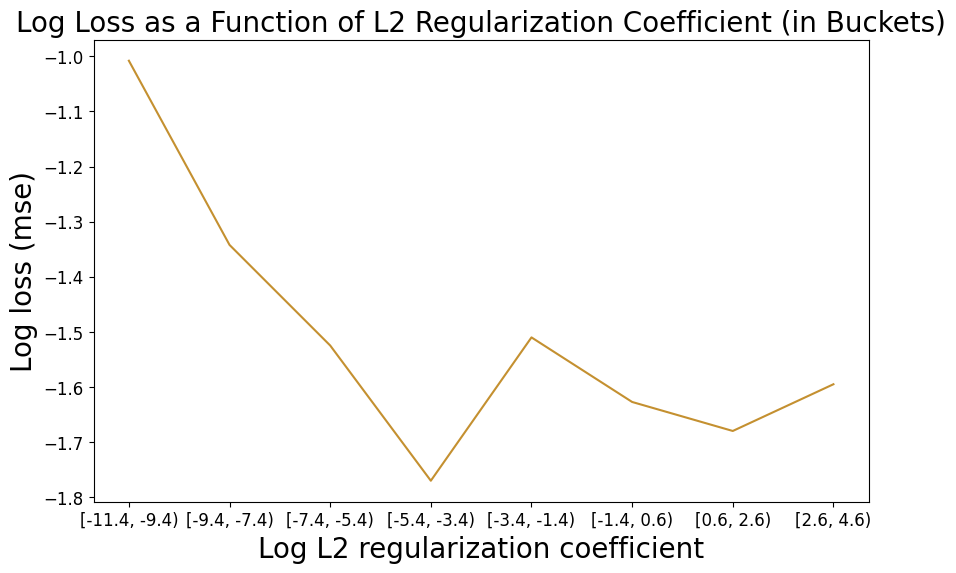

Index(['mse', 'bucket'], dtype='object')


/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_35114/1263575373.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_loss = loss_per_hyper.groupby('bucket').mean()


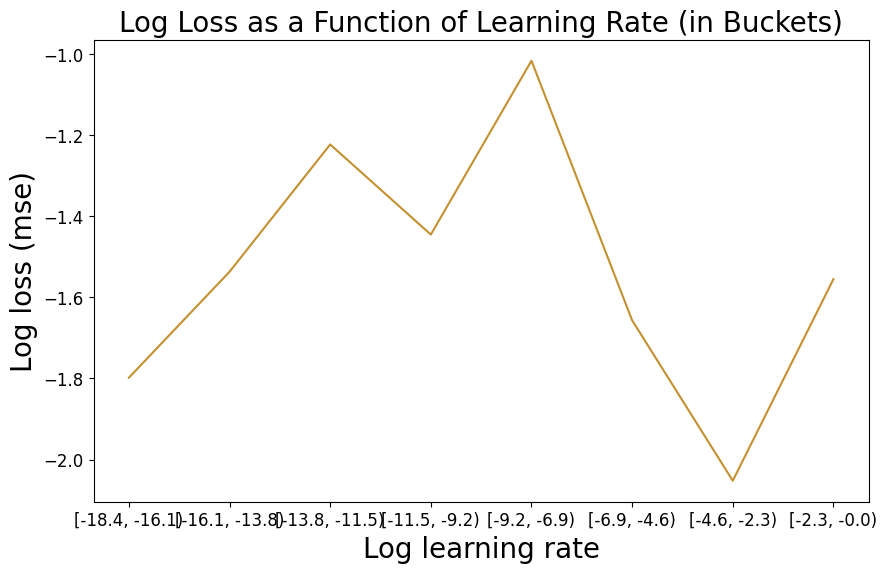

In [296]:
significant_tickers = ["KEY", "HAL", "BELFB", "FITB", "ESRT", "EPM", "BTU", "CWT", "ARTNA", "DOMO",]
config_loss_under = config_loss[config_loss["ticker"].isin(significant_tickers)]

columns = ["n_layers", "units", "l2_reg", "lr"]

plot_data = {
    "n_layers": {
        "title": "Loss as a Function of Number of Layers",
        "xlabel": "Number of layers",
        "ylabel": "Loss (mse)",
        "scale": "identity",
    },

    "units": {
        "title": "Loss as a Function of Number of Units in Each Layer",
        "xlabel": "Number units in each layer",
        "ylabel": "Loss (mse)",
        "scale": "identity",
    },

    "l2_reg": {
        "title": "Log Loss as a Function of L2 Regularization Coefficient (in Buckets)",
        "xlabel": "Log L2 regularization coefficient",
        "ylabel": "Log loss (mse)",
        "scale": "log",
    },

    "lr": {
        "title": "Log Loss as a Function of Learning Rate (in Buckets)",
        "xlabel": "Log learning rate",
        "ylabel": "Log loss (mse)",
        "scale": "log",
    },

}

for col in columns:
    # if col != "l2_reg":
    #     continue
    loss_per_hyper = config_loss_under.groupby(by=col)["mse"].mean()
    # print(loss_per_hyper)
    # break

    plt.figure(figsize=(10, 6))
    if col in ["l2_reg", "lr"]:
        loss_per_hyper.index = np.log(loss_per_hyper.index)
        num_buckets = 8
        bucket_edges = np.linspace(loss_per_hyper.index.min(), loss_per_hyper.index.max(), num_buckets + 1)

        # Assign each index to a bucket
        bucket_labels = range(1, num_buckets + 1)
        loss_per_hyper = pd.DataFrame(loss_per_hyper)
        bucket_labels = [f"[{bucket_edges[i]:.1f}, {bucket_edges[i + 1]:.1f})" for i in range(len(bucket_edges) - 1)]
        loss_per_hyper['bucket'] = pd.cut(loss_per_hyper.index, bins=bucket_edges, labels=bucket_labels, include_lowest=True)
        print(loss_per_hyper.columns)
        # Aggregate the loss values by buckets
        aggregated_loss = loss_per_hyper.groupby('bucket').mean()

        plt.plot(np.log(aggregated_loss), "#c49030")
    else:
        plt.plot(loss_per_hyper, "#c49030")
    plt.xlabel(plot_data[col]["xlabel"], fontsize = 20)
    plt.ylabel(plot_data[col]["ylabel"], fontsize = 20)
    plt.title(plot_data[col]["title"], fontsize = 20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f"5_{col}_loss_sig.png")
    plt.show()

In [89]:
significant_tickers = ["KEY", "HAL", "BELFB", "FITB", "ESRT", "EPM", "BTU", "CWT", "ARTNA", "DOMO",]

best_config_df = get_best_config_df(report)
best_config_df = best_config_df[best_config_df["index"].isin(significant_tickers)]
best_config_df = best_config_df.rename(columns={"index": "Ticker", "n_layers": "Number of layers", "units": "Units", "l2_reg": "L2 coefficient", "lr": "Learning rate"})

with open("optimal_hyper_significant.tex", "w") as file:
    latex_table = best_config_df.to_latex(
        index=False,
        header=True,
        float_format="%.5f",
        caption="Large variation in optimal hyperparameters across stocks.",
        label="tab:optimal_hyper_significant",
    )
    latex_table = latex_table.replace("\\begin{table}", "\\begin{table}[H]\n\\centering")
    file.write(latex_table)


In [90]:
significant_tickers = ["KEY", "HAL", "BELFB", "FITB", "ESRT", "EPM", "BTU", "CWT", "ARTNA", "DOMO",]

best_config_df = get_best_config_df(report)
best_config_df_over = best_config_df[best_config_df["index"].isin(significant_tickers)]
best_config_df_under = best_config_df[~best_config_df["index"].isin(significant_tickers)]
print(best_config_df_over.describe())
print(best_config_df_under.describe())



        n_layers      units     l2_reg         lr
count  10.000000  10.000000  10.000000  10.000000
mean    3.000000  18.400000   1.216756   0.007233
std     0.666667   7.589466   1.766179   0.007217
min     2.000000   8.000000   0.000747   0.000222
25%     3.000000  13.000000   0.034180   0.000749
50%     3.000000  16.000000   0.238164   0.005085
75%     3.000000  23.000000   1.988701   0.012812
max     4.000000  32.000000   5.424240   0.019282
        n_layers      units     l2_reg         lr
count  40.000000  40.000000  40.000000  40.000000
mean    3.425000  19.700000   7.643504   0.027664
std     1.034966   8.984888  19.755663   0.080832
min     2.000000   8.000000   0.000017   0.000136
25%     3.000000  12.000000   0.006264   0.003245
50%     3.000000  20.000000   0.062940   0.008916
75%     4.000000  28.000000   2.524644   0.020615
max     5.000000  32.000000  79.563130   0.511204


In [ ]:
def get_best_config_df(ticker: str, df: pd.DataFrame):
    config_loss_df = config_loss_df[config_loss_df["ticker"] == ticker]
    
    id_min_loss = config_loss_df["mse"].idxmin()
    config = config_loss_df.loc[id_min_loss,:]
    config = config.drop(index = ["ticker", "mse"])
    config = config.to_dict()
    return config


significant_tickers = ["KEY", "HAL", "BELFB", "FITB", "ESRT", "EPM", "BTU", "CWT", "ARTNA", "DOMO",]
cutoff_layer = 3
cutoff_width = 16

tot_config_df = pd.read_csv(f"../../reports_log/{report}/config_space_loss.csv")
tot_config_df = tot_config_df[tot_config_df["ticker"].isin(significant_tickers)]

tot_loss_df = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")[["ticker", "normalized_rmse"]]
best_config_df = tot_config_df.loc[tot_config_df.groupby('ticker')['mse'].idxmin()]

best_config_df = pd.merge(best_config_df, tot_loss_df, how="left", left_on="ticker", right_on="ticker")
best_config_df["vol"] = np.sqrt(best_config_df["mse"]) / best_config_df["normalized_rmse"]

# tot_config_df_big = tot_config_df[(tot_config_df["n_layers"] > cutoff_layer) & (tot_config_df["units"] > cutoff_width)]
# tot_config_df_small = tot_config_df[(tot_config_df["n_layers"] <= cutoff_layer) | (tot_config_df["units"] <= cutoff_width)]

tot_config_df["tot_units"] = tot_config_df["n_layers"]*tot_config_df["units"]

tot_config_df_big = tot_config_df[tot_config_df["tot_units"] >= tot_config_df["tot_units"].median()]
tot_config_df_small = tot_config_df[tot_config_df["tot_units"] < tot_config_df["tot_units"].median()]

big_configs_min_loss = (
    tot_config_df_big.loc[tot_config_df_big.groupby('ticker')['mse'].idxmin()]
    .assign(config_type='big')
)
small_configs_min_loss = (
    tot_config_df_small.loc[tot_config_df_small.groupby('ticker')['mse'].idxmin()]
    .assign(config_type='small')
)

comparison_df = pd.concat([big_configs_min_loss, small_configs_min_loss])

comparison_df = comparison_df.sort_values(by='ticker').reset_index(drop=True)
comparison_df = pd.merge(comparison_df, best_config_df[["normalized_rmse", "mse", "vol"]], how="left", left_on="mse", right_on="mse")
comparison_df['vol'] = (
    comparison_df.groupby('ticker')['vol']
    .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
)
comparison_df["normalized_rmse"] = np.sqrt(comparison_df["mse"])/comparison_df["vol"]
comparison_df = comparison_df[["ticker", "n_layers", "units", "l2_reg", "lr", "config_type", "normalized_rmse"]]

with open("FILENAME.tex", "w") as file:
    latex_table = comparison_df.to_latex(
        index=False,
        header=True,
        float_format="%.2f",
        caption="CAPTION",
        label="tab:LABEL",
    )

    latex_table = latex_table.replace(
        "\\begin{table}", 
        "\\begin{table}[H]\n\\centering\n\\small"
    )
    file.write(latex_table)

comparison_df

/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_35114/2547020068.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


,ticker,n_layers,units,l2_reg,lr,config_type,normalized_rmse
0,ARTNA,4.0,20.0,5.424240,0.000542,big,0.999185
1,ARTNA,4.0,12.0,97.358361,0.544114,small,0.999896
2,BELFB,5.0,28.0,0.010166,0.052933,big,0.995457
3,BELFB,3.0,16.0,2.531942,0.001370,small,0.988091
4,BTU,3.0,24.0,0.002513,0.035980,big,1.000906
5,BTU,3.0,12.0,0.060697,0.015907,small,0.998377
6,CWT,2.0,32.0,2.154399,0.002420,big,0.998495
7,CWT,4.0,8.0,1.253521,0.039026,small,1.001678
8,DOMO,2.0,32.0,7.886164,0.000439,big,0.999999
9,DOMO,2.0,16.0,1.491607,0.000222,small,0.999579


In [137]:
df_tot_loss = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")
some_random_tickers = np.random.choice(df_tot_loss["ticker"], 5)

In [138]:
some_random_tickers

array(['FGBI', 'CIVB', 'MARA', 'BKD', 'AMED'], dtype=object)

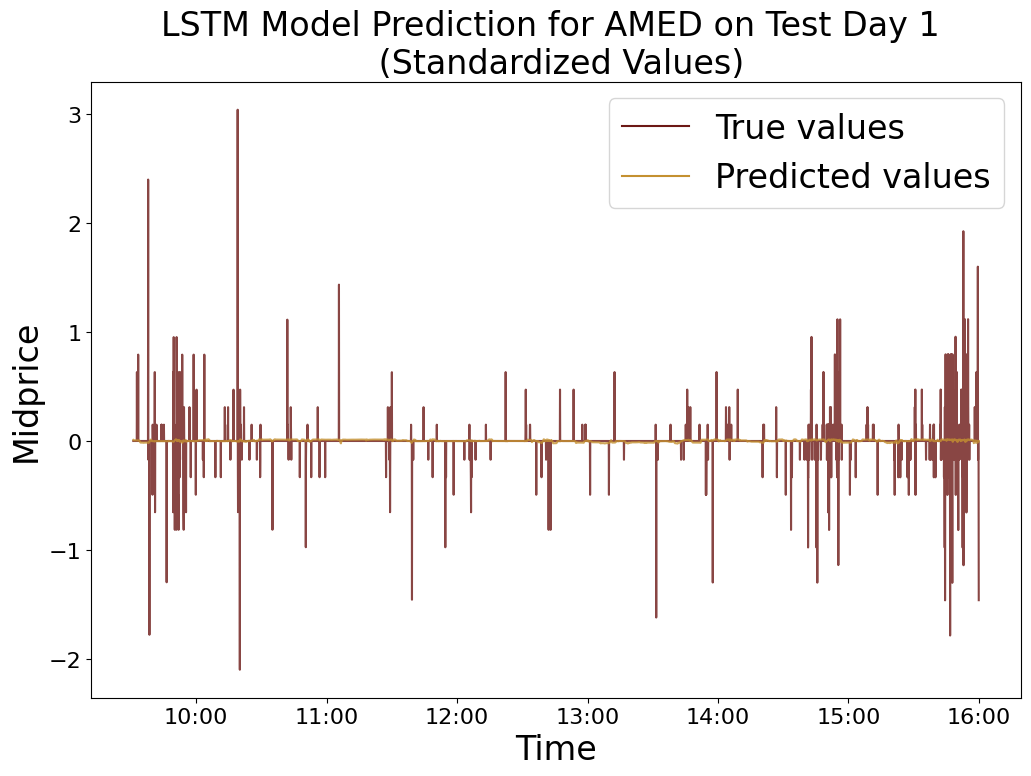

In [306]:
def get_prediction(df, ticker, test_day):
    config = get_best_config(ticker)

    ticker_data = df[df["ticker"] == ticker].copy()
    ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
    ticker_data["date"] = ticker_data["sip_timestamp"].dt.date

    date_scheme = get_dates_for_training_scheme(ticker_data)

    num_days_testing = 6
    date_scheme_test = date_scheme[-num_days_testing:]
        
    date_set = date_scheme_test[test_day]

    train, test = train_val_test(ticker_data, date_set)

    scaler = StandardScaler()

    ts = test["sip_timestamp"].iloc[config["seq_length"]:]

    train = train.drop(columns=["ticker", "sip_timestamp"])
    test = test.drop(columns=["ticker", "sip_timestamp"])

    scaler = StandardScaler()

    columns_to_standardize = train.columns[:-1] # standardize all columns except date

    for col in columns_to_standardize:
        scaler.fit(train.loc[train[col] != 0, [col]])
        train.loc[train[col] != 0, col] = scaler.transform(train.loc[train[col] != 0, [col]])
        test.loc[test[col] != 0, col] = scaler.transform(test.loc[test[col] != 0, [col]])

    X_train, y_train = create_sequences_modified(train, config["seq_length"])
    X_test, y_test = create_sequences_modified(test, config["seq_length"])

    model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

    y_pred = model.predict(X_test, verbose=False).flatten()

    # scaling back
    # test.loc[test[col] != 0, col] = scaler.inverse_transform(test.loc[test[col] != 0, [col]])
    # y_pred = scaler.inverse_transform(y_pred)

    return ts, test.iloc[config["seq_length"]:, -2], y_pred


ticker = "AMED"
test_day = 0
ts, y_test, y_pred = get_prediction(df, ticker, test_day)
ts = ts - pd.Timedelta(hours=4)

colors = ["#c49030", "#6c1815"]  
plt.figure(figsize=(12, 8))

plt.plot(ts, y_test, color = "#6c1815", alpha=0.8)
plt.plot(ts, y_pred, color = "#c49030", alpha=0.8)
plt.plot([], [], color="#6c1815", label="True values", alpha=1)
plt.plot([], [], color="#c49030", label="Predicted values", alpha=1)
plt.legend(fontsize=24)
plt.title(f"LSTM Model Prediction for {ticker} on Test Day {test_day + 1} \n (Standardized Values)", fontsize = 24)
plt.ylabel("Midprice", fontsize = 24)
plt.xlabel("Time", fontsize = 24)
ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig(f"5_{ticker}_{test_day}.png")
plt.show()

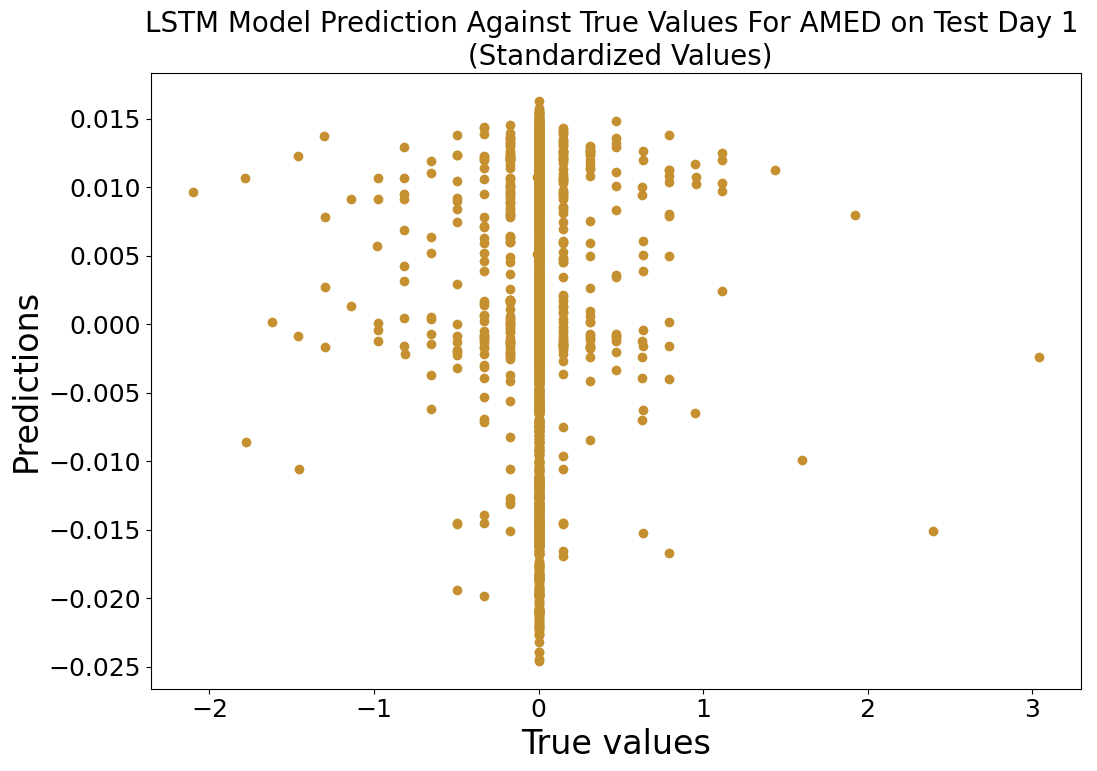

In [307]:
ticker = "AMED"
test_day = 0
ts, y_test, y_pred = get_prediction(df, ticker, test_day)

plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred, color = "#c49030")
plt.title(f"LSTM Model Prediction Against True Values For {ticker} on Test Day {test_day + 1} \n (Standardized Values)", fontsize = 20)
plt.ylabel("Predictions", fontsize = 24)
plt.xlabel("True values", fontsize = 24)
plt.tick_params(axis='both', labelsize = 18)

plt.savefig(f"5_{ticker}_{test_day}_scatter.png")
plt.show()

0.12372994780054172


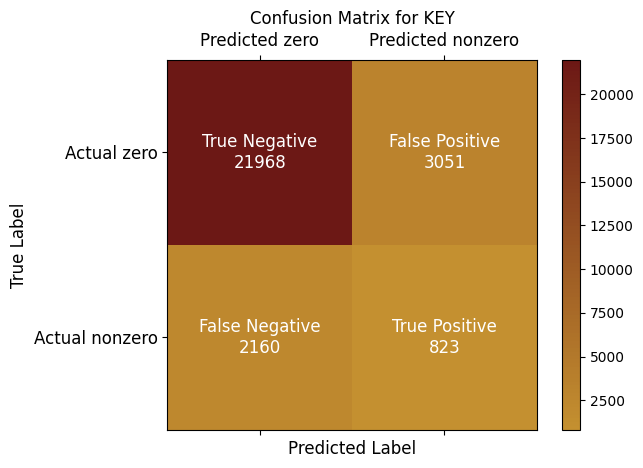

In [312]:
ticker = "KEY"
confusion_df = predictions_df.loc[predictions_df["ticker"] == ticker, ["pred_y", "true_y"]]
share_zero_values = (predictions_df["true_y"] == 0).sum()/predictions_df.shape[0]
alpha = 1-share_zero_values
upper_quantile = confusion_df["pred_y"].quantile(1 - alpha/2)
lower_quantile = confusion_df["pred_y"].quantile(alpha/2)

# upper_quantile = 0.1*confusion_df.loc[confusion_df["true_y"] != 0, "true_y"].std()
# lower_quantile = -0.1*confusion_df.loc[confusion_df["true_y"] != 0, "true_y"].std()
# upper_quantile = 0.1*confusion_df["true_y"].std()
# lower_quantile = -0.1*confusion_df["true_y"].std()

print(upper_quantile)

confusion_df["predicted"] = np.where((confusion_df["pred_y"] >= upper_quantile) | (confusion_df["pred_y"] <= lower_quantile), 1, 0)

# confusion_df['predicted'] = (
#     ((confusion_df['true_y'] > 1) & (confusion_df['pred_y'] >= 0.1 * confusion_df['true_y'])) |
#     ((confusion_df['true_y'] < 0) & (confusion_df['pred_y'] <= 0.1 * confusion_df['true_y']))
# ).astype(int)
confusion_df["transformed_true_y"] = np.where(confusion_df["true_y"] != 0, 1, 0)

# Generate confusion matrix
true_labels = confusion_df["transformed_true_y"]
predicted_labels = confusion_df["predicted"]
cm = confusion_matrix(true_labels, predicted_labels)

# Customize labels for confusion matrix
custom_labels = [
    "True Negative",  # Top-left
    "False Positive",  # Top-right
    "False Negative",  # Bottom-left
    "True Positive"  # Bottom-right
]

# Plot the confusion matrix with custom labels
colors = ["#c49030", "#6c1815"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=custom_cmap)
plt.colorbar(cax)

# Set labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Predicted zero", "Predicted nonzero"], fontsize = 12)
ax.set_yticklabels(["Actual zero", "Actual nonzero"], fontsize = 12)

# Add text annotations
for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f"{custom_labels[i * 2 + j]}\n{value}", ha='center', va='center', color="white", fontsize = 12)

plt.title(f"Confusion Matrix for {ticker}", fontsize = 12)
plt.xlabel("Predicted Label", fontsize = 12)
plt.ylabel("True Label", fontsize = 12)
plt.savefig(f"5_confusion_matrix_{ticker}.png", bbox_inches='tight')
plt.show()


### Diebold Mariano

In [ ]:
def get_predictions(df, ticker):

    config = get_best_config(ticker)

    ticker_data = df[df["ticker"] == ticker].copy()
    ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
    ticker_data["date"] = ticker_data["sip_timestamp"].dt.date

    date_scheme = get_dates_for_training_scheme(ticker_data)

    num_days_testing = 6
    date_scheme_test = date_scheme[-num_days_testing:]

    tot_predictions = np.array([])
    tot_true = np.array([])

    for test_day in range(6):
        
        date_set = date_scheme_test[test_day]

        train, test = train_val_test(ticker_data, date_set)

        scaler = StandardScaler()

        ts = test["sip_timestamp"].iloc[config["seq_length"]:]

        train = train.drop(columns=["ticker", "sip_timestamp"])
        test = test.drop(columns=["ticker", "sip_timestamp"])

        scaler = StandardScaler()

        columns_to_standardize = train.columns[:-1] # standardize all columns except date

        for col in columns_to_standardize:
            scaler.fit(train.loc[train[col] != 0, [col]])
            train.loc[train[col] != 0, col] = scaler.transform(train.loc[train[col] != 0, [col]])
            test.loc[test[col] != 0, col] = scaler.transform(test.loc[test[col] != 0, [col]])

        X_train, y_train = create_sequences_modified(train, config["seq_length"])
        X_test, y_test = create_sequences_modified(test, config["seq_length"])

        model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

        y_pred = model.predict(X_test, verbose=False)
        
        tot_true = np.concatenate((tot_true, test.iloc[config["seq_length"]:, -2]))
        tot_predictions = np.concatenate((tot_predictions, y_pred.flatten()))

    return tot_true, tot_predictions, np.array([0]*tot_true.shape[0])


0.7304470954929776
1.183396393460291e-06
0.13782923572065664
0.04760041365326088
0.5798757257674213
0.05938339226064833
0.05906423619904016
0.37387046150405423
2.803624175641012e-06
0.0010537021239502072
2.2026277156085253e-31
0.2587531714069011
4.808542624244787e-17


### Some tables for latex

In [105]:
df_loss = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")
df_table = pd.DataFrame()

tickers = []
losses = []
p_values = []
for tick in df_loss["ticker"]:
    print(tick)
    tickers.append(tick)
    a = get_predictions(df, tick)
    normalized_rmse = np.mean((a[1]-a[0])**2)**0.5 / np.std(a[0])
    losses.append(normalized_rmse)
    stat, p = dm_test(*a, h=int((a[0].shape[0]/1000)**0.25))
    p_values.append(p)

df_table["P-value"] = p_values
df_table["ticker"] = tickers
df_table["normalized_rmse"] = losses
df_table = df_table.sort_values(by="normalized_rmse", ascending=True)
df_table = df_table[df_table["normalized_rmse"] < 1]

df_table = df_table.rename(columns={"ticker": "Ticker", "normalized_rmse": "Normalized RMSE"})

with open("loss_per_ticker_0.tex", "w") as file:
    latex_table = df_table[["Ticker", "Normalized RMSE", "P-value"]].to_latex(
        index=False,
        header=True,
        float_format="%.5f",
        caption="Loss per ticker",
        label="tab:loss_per_ticker_0",
    )
    latex_table = latex_table.replace("\\begin{table}", "\\begin{table}[H]\n\\centering")
    file.write(latex_table)


ADSK
AEP
AHH
ALEC
AMED
APYX
ARTNA
ARVN
BANF
BELFB
BKD
BTU
BV
CB
CFBK
CHE
CIVB
CLDX
CNA
COHU
CRBP
CRMD
CRMT
CWT
DOMO
DVAX
EAF
EPM
ESRT
EVTC
FDS
FGBI
FITB
FULT
FWONA
GCI
GDDY
GNE
HAL
HLF
HTBI
IBCP
ICAD
IPG
JELD
KEY
LYTS
MARA
MEDP
MESA


In [218]:
# Read the CSV and rename columns
df_loss = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")
df_loss = df_loss.rename(columns={"ticker": "Ticker", "normalized_rmse": "Normalized RMSE"})
df_loss = df_loss[["Ticker", "Normalized RMSE"]]

# Split the DataFrame into two halves
half = len(df_loss) // 2 + len(df_loss) % 2  # Ensure odd numbers split correctly
df_left = df_loss.iloc[:half]
df_right = df_loss.iloc[half:]

# Create the LaTeX table
with open("appendix_B.tex", "w") as file:
    # Start table
    latex_table = "\\begin{table}[H]\n\\centering\n"
    latex_table += "\\caption{Loss per ticker}\n\\label{tab:appendix_B}\n"
    latex_table += "\\begin{tabular}{l r l r}\n"
    latex_table += "\\toprule\n"
    latex_table += "\\multicolumn{2}{c}{Column 1} & \\multicolumn{2}{c}{Column 2} \\\\\n"
    latex_table += "\\cmidrule(r){1-2} \\cmidrule(r){3-4}\n"
    latex_table += "Ticker & Normalized RMSE & Ticker & Normalized RMSE \\\\\n"
    latex_table += "\\midrule\n"

    # Add rows from both halves
    for i in range(half):
        left_row = (
            f"{df_left.iloc[i, 0]} & {df_left.iloc[i, 1]:.5f}"
            if i < len(df_left)
            else "&"
        )
        right_row = (
            f"{df_right.iloc[i - half, 0]} & {df_right.iloc[i - half, 1]:.5f}"
            if i - half < len(df_right)
            else "&"
        )
        latex_table += f"{left_row} & {right_row} \\\\\n"

    # End table
    latex_table += "\\bottomrule\n"
    latex_table += "\\end{tabular}\n"
    latex_table += "\\end{table}\n"

    # Write to file
    file.write(latex_table)


In [215]:
df_loss = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")
meta_data = pd.read_csv("../../data/raw/meta_data.csv", index_col=1).iloc[:, 1:].reset_index()
meta_data = meta_data.merge(df_loss, how="inner", left_on="ticker", right_on="ticker")
meta_data = meta_data[["ticker", "sectorKey", "industryKey"]]

def get_company_details(ticker):
    try:
        company_info = yf.Ticker(ticker).info
        company_name = company_info.get('longName', "Name Not Found")
        sector = company_info.get('sectorKey', "Sector Not Found")
        industry = company_info.get('industryKey', "Industry Not Found")
        return company_name, sector, industry
    except Exception as e:
        return "Name Not Found", "Sector Not Found", "Industry Not Found"

# Apply the function and expand into separate columns
meta_data[["companyName", "sectorKey", "industryKey"]] = meta_data['ticker'].apply(
    lambda ticker: pd.Series(get_company_details(ticker))
)
meta_data = meta_data.rename(columns={"ticker": "Ticker", "companyName": "Company Name", "sectorKey": "Sector", "industryKey": "Industry"})
meta_data = meta_data[["Ticker", "Company Name", "Sector", "Industry"]]

with open("appendix_A.tex", "w") as file:
    latex_table = meta_data.to_latex(
        index=False,
        header=True,
        float_format="%.2f",
        caption="Overview of companies with tickers, name, sector, and industry",
        label="tab:appendix_A",
    )

    latex_table = latex_table.replace(
        "\\begin{table}", 
        "\\begin{table}[H]\n\\centering\n\\small"
    )
    file.write(latex_table)

meta_data

,Ticker,Company Name,Sector,Industry
0,ADSK,"Autodesk, Inc.",technology,software-application
1,AEP,"American Electric Power Company, Inc.",utilities,utilities-regulated-electric
2,AHH,"Armada Hoffler Properties, Inc.",real-estate,reit-diversified
3,ALEC,"Alector, Inc.",healthcare,biotechnology
4,AMED,"Amedisys, Inc.",healthcare,medical-care-facilities
5,APYX,Apyx Medical Corporation,healthcare,medical-devices
6,ARTNA,Artesian Resources Corporation,utilities,utilities-regulated-water
7,ARVN,"Arvinas, Inc.",healthcare,biotechnology
8,BANF,BancFirst Corporation,financial-services,banks-regional
9,BELFB,Bel Fuse Inc.,technology,electronic-components


In [ ]:
best_config_df = get_best_config_df(report)

best_config_df = best_config_df.rename(columns= {
    "index": "Ticker",
    "n_layers": "Number of layers",
    "units": "Units",
    "l2_reg": "L2 coefficient",
    "lr": "Learning rate"
})

with open("appendix_C.tex", "w") as file:
    latex_table = best_config_df.to_latex(
        index=False,
        header=True,
        float_format="%.5f",
        caption="Best hyperparameters for each ticker",
        label="tab:appendix_C",
    )

    latex_table = latex_table.replace(
        "\\begin{table}", 
        "\\begin{table}[H]\n\\centering\n\\small"
    )
    file.write(latex_table)

best_config_df



,Ticker,Number of layers,Units,L2 coefficient,Learning rate
0,ADSK,4,24,2.888071,0.000864
1,AEP,5,32,0.000107,0.002361
2,AHH,2,28,2.592566,0.016918
3,ALEC,4,28,0.041621,0.006253
4,AMED,5,8,0.047834,0.003183
5,APYX,5,20,0.978264,0.000376
6,ARTNA,4,20,5.424240,0.000542
7,ARVN,2,16,0.003339,0.004486
8,BANF,3,8,0.033302,0.008452
9,BELFB,3,16,2.531942,0.001370


In [58]:
X = pd.read_csv("../../data/raw/meta_data.csv", index_col=1).iloc[:, 1:]
df_loss = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")
tickers = df_loss["ticker"]

X = X.loc[tickers, :]

excluded_cols = [
    "sectorKey", 
    "industryKey",
    "auditRisk",
    "boardRisk",
    "compensationRisk",
    "shareHolderRightsRisk",
    "overallRisk",
]

X = X.drop(columns = excluded_cols)
features = pd.DataFrame(columns=["Feature", "Description"])
features["Feature"] = X.columns

with open("appendix_D.tex", "w") as file:
    latex_table = features.to_latex(
        index=False,
        header=True,
        float_format="%.5f",
        caption="Fundamental data used in regression",
        label="tab:appendix_D",
    )

    latex_table = latex_table.replace(
        "\\begin{table}", 
        "\\begin{table}[H]\n\\centering\n\\small"
    )
    file.write(latex_table)

features

,Feature,Description
0,fullTimeEmployees,NaN
1,dividendRate,NaN
2,dividendYield,NaN
3,fiveYearAvgDividendYield,NaN
4,beta,NaN
5,trailingPE,NaN
6,forwardPE,NaN
7,marketCap,NaN
8,priceToSalesTrailing12Months,NaN
9,enterpriseValue,NaN


In [18]:
df_loss = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv")

shapes = []

for ticker in df_loss["ticker"].unique():
    ticker_data = df[df["ticker"] == ticker]
    shapes.append(ticker_data.shape[0])

print(shapes) 
print(sum(shapes))
print(max(shapes))
print(min(shapes))

[93580, 93580, 93580, 93580, 93580, 93495, 93580, 93580, 93580, 93580, 93580, 93580, 93579, 93580, 91799, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93576, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580, 93580]
4677129
93580
91799
